party
REPUBLICAN    2596
DEMOCRAT       559
Name: count, dtype: int64
Unique county number check, should be 3155: 3155
Number of rows omitted due to data type conversion for republican_Data: 330
Number of rows omitted due to data type conversion for democrat_data: 330
Data types after conversion:
Republican data types:
voteshare                 float64
poverty_rate              float64
less_HS                   float64
Unemployment_rate_2020    float64
HS                        float64
bachelor                  float64
int_mig                   float64
total_mig                 float64
rucc                      float64
dtype: object
Democrat data types:
voteshare                 float64
poverty_rate              float64
less_HS                   float64
Unemployment_rate_2020    float64
HS                        float64
bachelor                  float64
int_mig                   float64
total_mig                 float64
rucc                      float64
dtype: object
Correlation betwee

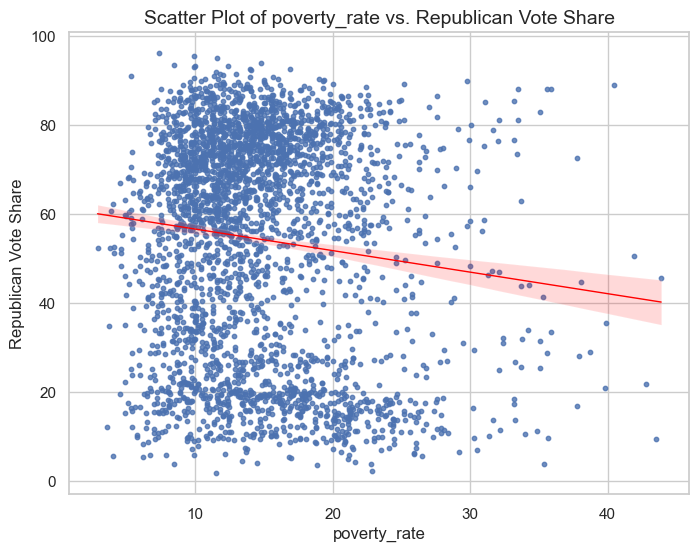

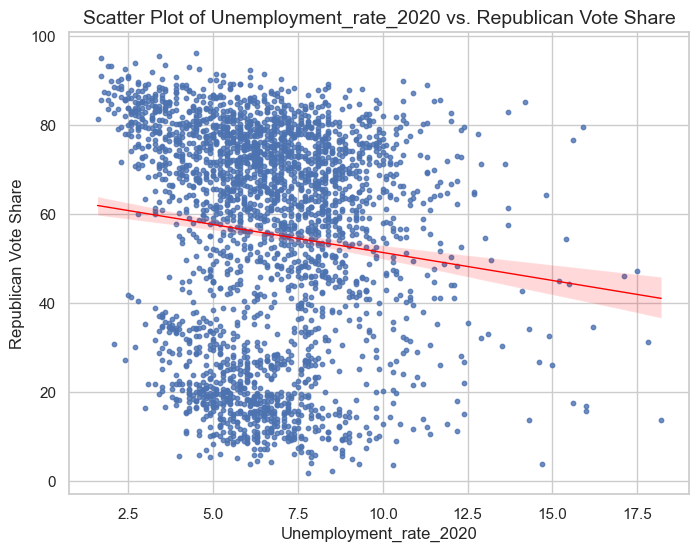

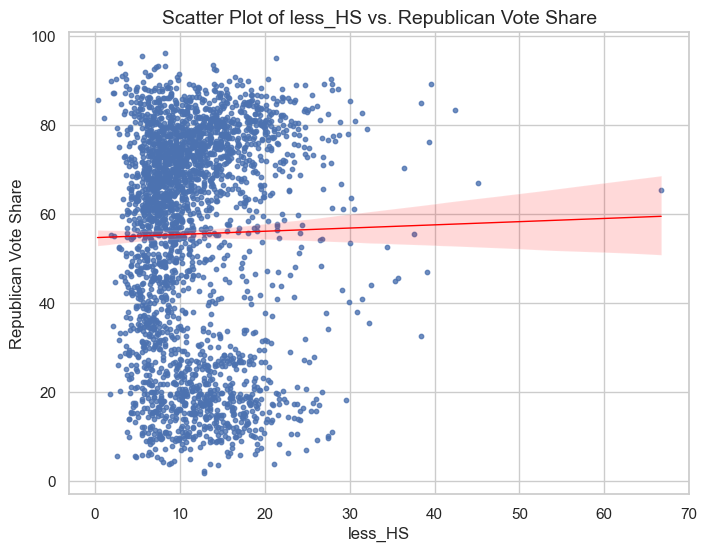

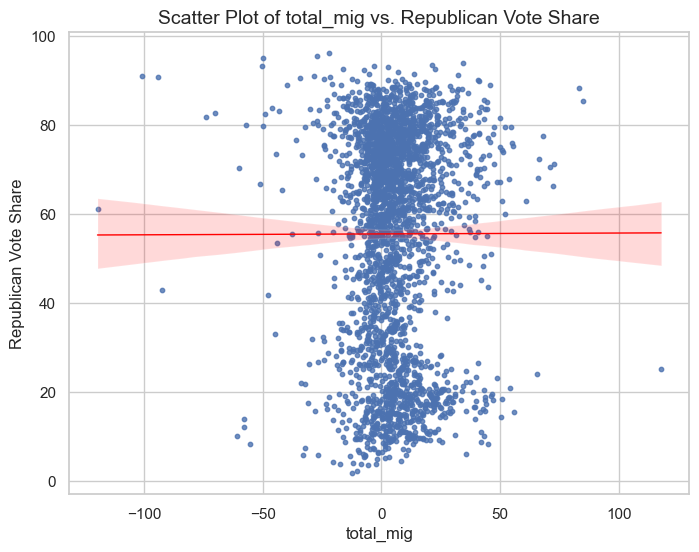

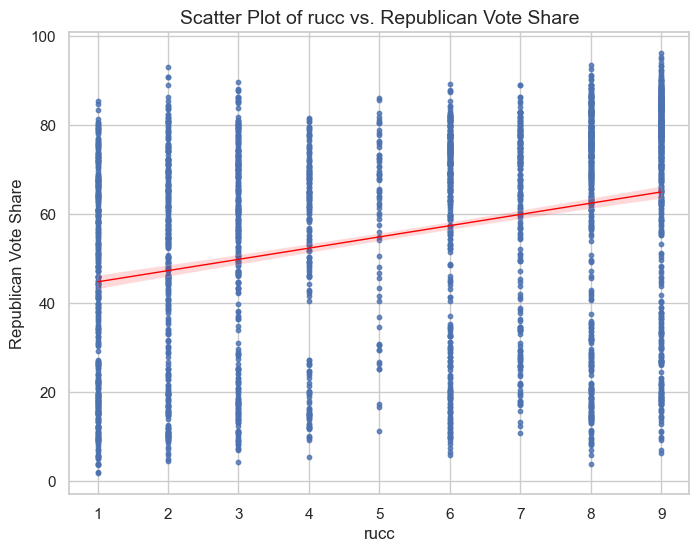

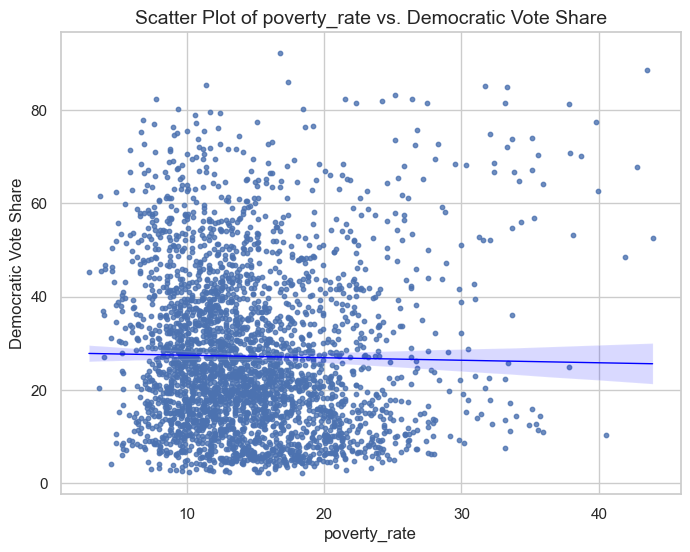

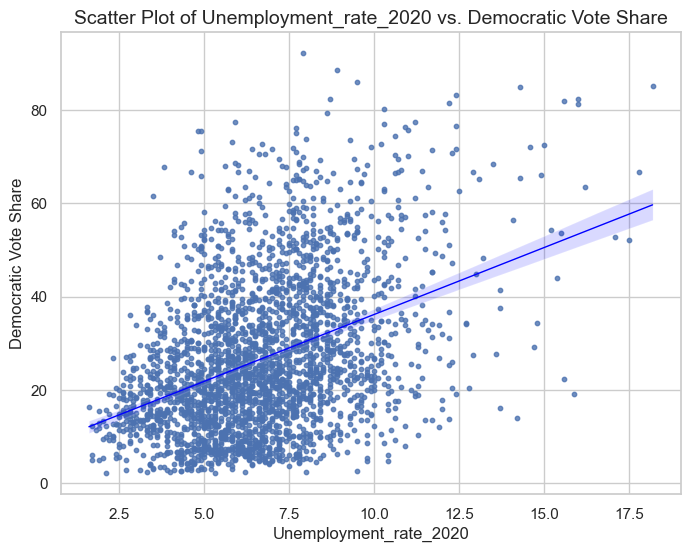

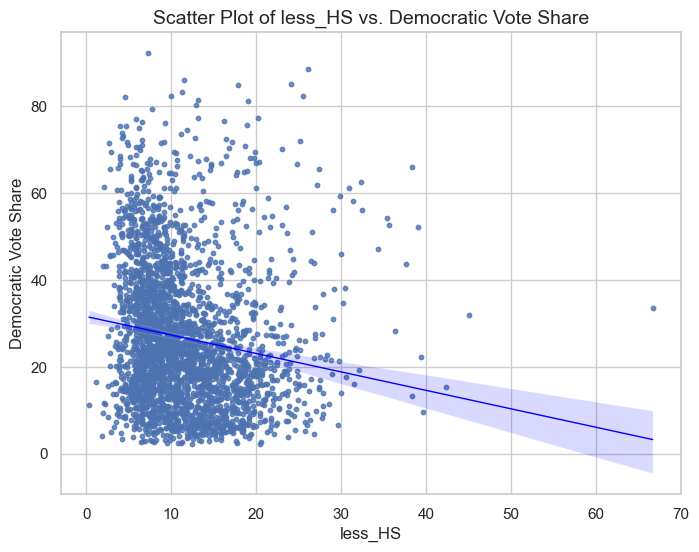

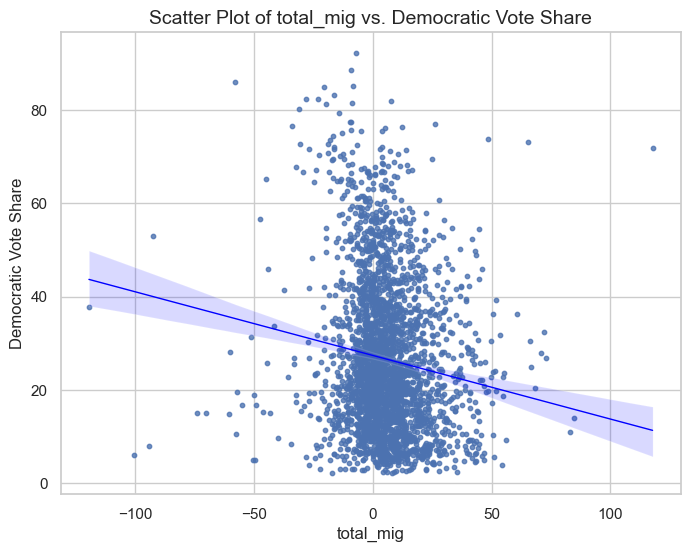

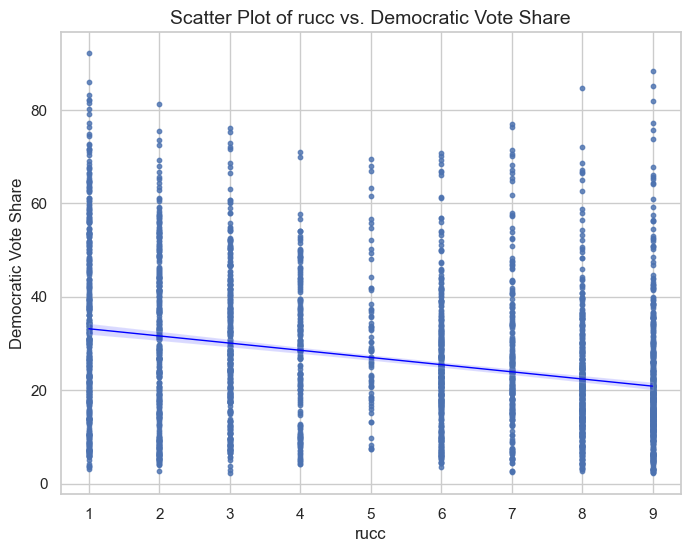

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'FIPS'],
      dtype='object')
Index(['state', 'party', 'county_name', 'county_fips', 'candidate',
       'candidatevotes', 'totalvotes', 'voteshare', 'poverty_rate',
       'Unemployment_rate_2020', 'less_HS', 'HS', 'bachelor', 'int_mig',
       'total_mig', 'rucc', 'winner', 'RUCC_category', 'state_winner'],
      dtype='object')
Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')
122


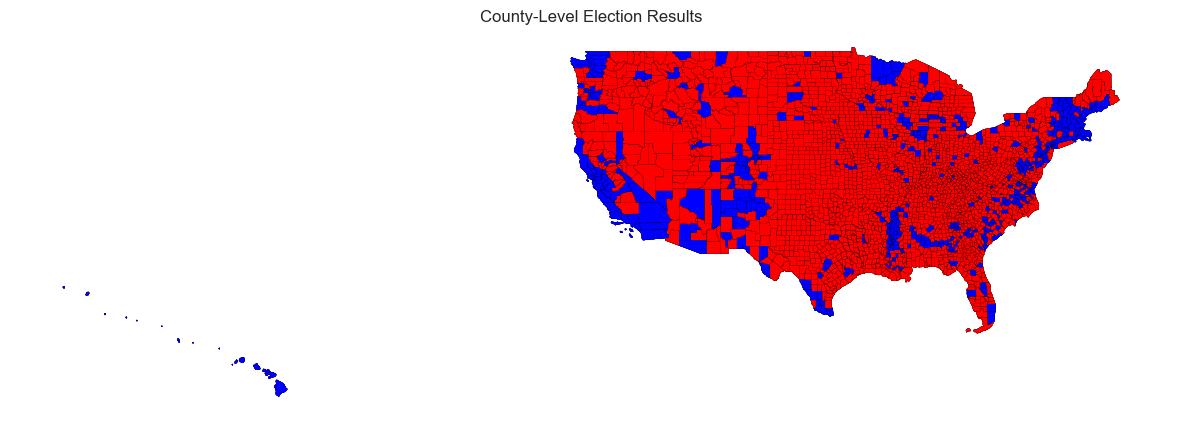

Unique GEOIDs in counties shapefile:
0     31039
1     53069
2     35011
3     31109
4     31129
      ...  
95    42117
96    31043
97    26089
98    51181
99    48391
Name: GEOID, Length: 100, dtype: object

Unique county_fips in df:
0     10001
1     10001
2     10001
3     10001
4     10003
      ...  
95    01055
96    01057
97    01057
98    01057
99    01059
Name: county_fips, Length: 100, dtype: object
Unmatched county_fips in df:
['02001' '02002' '02003' '02004' '02005' '02006' '02007' '02008' '02009'
 '02010' '02011' '02012' '02014' '02015' '02017' '02018' '02019' '02021'
 '02022' '02023' '02024' '02025' '02026' '02027' '02028' '02029' '02030'
 '02031' '02032' '02033' '02034' '02035' '02036' '02037' '02038' '02039'
 '02040' '02099' '2938000' '000NA']
Unmatched GEOIDs in counties shapefile:
['72085' '02130' '72115' '78030' '72105' '02188' '72053' '72151' '72067'
 '02220' '72127' '72049' '72051' '72121' '72039' '72133' '72139' '72073'
 '72097' '02290' '72029' '72123' '72103' '0

In [72]:
#Packages and libraries
import pyodbc
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import geopandas as gpd
import geodatasets

########### Fetching data from SQL server SSMS ###########################

# Variables for connecting to local SSMS SQL server
server = 'LAPTOP'
database = 'elec_county'
driver = '{ODBC Driver 18 for SQL Server}'
conn = pyodbc.connect(
    f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;Encrypt=Yes;TrustServerCertificate=Yes;'
)

# SQL Query spelled out, previously tested in SSMS
query = """
SELECT c.state,
       c.party,
       c.county_name,
       c.county_fips,
       c.candidate,
       SUM(c.candidatevotes) AS candidatevotes,  -- Sum candidate votes
       SUM(c.totalvotes) AS totalvotes,          -- Sum total votes
       CAST(SUM(c.candidatevotes) AS DECIMAL(18, 2)) / NULLIF(CAST(SUM(c.totalvotes) AS DECIMAL(18, 2)), 0) * 100 AS voteshare,
       p.PCTPOVALL_2021 AS poverty_rate,
       u.Unemployment_rate_2020,
       e.Percent_of_adults_with_less_than_a_high_school_diploma_2018_22 AS less_HS,
       e.Percent_of_adults_with_a_high_school_diploma_only_2018_22 AS HS,
       e.Percent_of_adults_with_a_bachelor_s_degree_or_higher_2018_22 AS bachelor,
       pop.R_INTERNATIONAL_MIG_2021 AS int_mig,
       pop.R_NET_MIG_2021 AS total_mig,
       pop.Rural_Urban_Continuum_Code_2023 AS rucc
FROM elec_county.dbo.countypres AS c
LEFT JOIN elec_county.dbo.poverty AS p ON c.county_fips = p.FIPS_Code
LEFT JOIN elec_county.dbo.unemployment AS u ON c.county_fips = u.FIPS_Code
LEFT JOIN elec_county.dbo.Education AS e ON c.county_fips = e.FIPS_Code
LEFT JOIN elec_county.dbo.PopulationEstimates AS pop ON c.county_fips = pop.FIPStxt
WHERE c.year = 2020
GROUP BY c.state, c.party, c.county_name, c.county_fips, c.candidate, c.year, p.PCTPOVALL_2021, u.Unemployment_rate_2020,
         e.Percent_of_adults_with_less_than_a_high_school_diploma_2018_22,
         e.Percent_of_adults_with_a_high_school_diploma_only_2018_22,
         e.Percent_of_adults_with_a_bachelor_s_degree_or_higher_2018_22,
         pop.R_INTERNATIONAL_MIG_2021, pop.R_NET_MIG_2021,
         pop.Rural_Urban_Continuum_Code_2023
ORDER BY c.year, c.county_fips;
"""

# Getting SQL data
cursor = conn.cursor()
cursor.execute(query)
columns = [column[0] for column in cursor.description]
data = cursor.fetchall()
conn.close()

# Ensure rows are structured appropriately
results = [list(row) for row in data]  # Convert rows to a python list of lists
df = pd.DataFrame(results, columns=columns)

# Filter data for republican party and democratic party
republican_data = df[df['party'] == 'REPUBLICAN'].copy()
democrat_data = df[df['party'] == 'DEMOCRAT'].copy()

########### Fetching data from SQL server #################


################# Start Adding column for winning party ie party with a plurality of voteshare ########################

parties = df['party'].unique()


winning_party = df.loc[df.groupby('county_fips')['voteshare'].idxmax()]
party_wins = winning_party['party'].value_counts()
print(party_wins)

# group by county
winning_party_indices = df.groupby('county_fips')['voteshare'].idxmax()
winning_party = df.loc[winning_party_indices, ['county_fips', 'party']]
df = df.merge(winning_party, on='county_fips', suffixes=('', '_winner'))
df['winner'] = df['party_winner']
df = df.drop(columns=['party_winner'])

unique_counties = df['county_fips'].nunique()
print(f"Unique county number check, should be 3155: {unique_counties}")

################# End Adding column for winning party ##################

################## Start Converting columns used in correlation calcs to numeric values ###################

#Convert columns to numeric data type
convert_to_numeric = ['voteshare','poverty_rate','less_HS','Unemployment_rate_2020','HS','bachelor','int_mig','total_mig','rucc']
republican_data[convert_to_numeric] = republican_data[convert_to_numeric].apply(pd.to_numeric, errors='coerce')
republican_rowcount_orig = republican_data.shape[0]

# Count rows after conversion and dropping NaN
converted_count = republican_data.dropna(subset=convert_to_numeric).shape[0]

# Calculate number of deleted rows
omitted_rows = republican_rowcount_orig - converted_count
print(f"Number of rows omitted due to data type conversion for republican_Data: {omitted_rows}")

# For Democrat data
original_count_democrat = democrat_data.shape[0]
democrat_data[convert_to_numeric] = democrat_data[convert_to_numeric].apply(pd.to_numeric, errors='coerce')
converted_count_democrat = democrat_data.dropna(subset=convert_to_numeric).shape[0]
omitted_rows_democrat = original_count_democrat - converted_count_democrat
print(f"Number of rows omitted due to data type conversion for democrat_data: {omitted_rows_democrat}")

# Check if the conversion worked
print("Data types after conversion:")
print("Republican data types:")
print(republican_data[convert_to_numeric].dtypes)
print("Democrat data types:")
print(democrat_data[convert_to_numeric].dtypes)

############### End Converting columns #####################

############### Pearson Correlation Calculations Start ###########################

# Calculate correlation for republican party voteshare - poverty rate
rep_corr_data = republican_data.dropna(subset=['poverty_rate', 'voteshare'])
if rep_corr_data.shape[0] >= 2:
    corr_republican, p_value_republican = pearsonr(rep_corr_data['poverty_rate'], rep_corr_data['voteshare'])
    print(f"Correlation between poverty rate and Republican vote share: {corr_republican:.2f} (p-value: {p_value_republican:.3f})")
else:
    print("Not enough data to calculate correlation for Republican party (poverty rate).")

# Calculate correlation for Democrat party voteshare - poverty rate
dem_corr_data = democrat_data.dropna(subset=['poverty_rate', 'voteshare'])
if dem_corr_data.shape[0] >= 2:
    corr_democrat, p_value_democrat = pearsonr(dem_corr_data['poverty_rate'], dem_corr_data['voteshare'])
    print(f"Correlation between poverty rate and Democrat vote share: {corr_democrat:.2f} (p-value: {p_value_democrat:.3f})")
else:
    print("Not enough data to calculate correlation for Democrat party (poverty rate).")

# Correlation for Republican party voteshare - percentage of ppl with less than HS education
rep_corr_data_HS = republican_data.dropna(subset=['less_HS', 'voteshare'])
if rep_corr_data_HS.shape[0] >= 2:
    corr_republican_HS, p_value_republican_HS = pearsonr(rep_corr_data_HS['less_HS'], rep_corr_data_HS['voteshare'])
    print(f"HSrepub: {corr_republican_HS:.2f} (p-value: {p_value_republican_HS:.3f})")
else:
    print("Not enough data to calculate correlation for Republican party (less_HS).")

# Correlation for Democrat party voteshare - percentage of ppl with less than HS education
dem_corr_data_HS = democrat_data.dropna(subset=['less_HS', 'voteshare'])
if dem_corr_data_HS.shape[0] >= 2:
    corr_democrat_HS, p_value_democrat_HS = pearsonr(dem_corr_data_HS['less_HS'], dem_corr_data_HS['voteshare'])
    print(f"HSdemoc: {corr_democrat_HS:.2f} (p-value: {p_value_democrat_HS:.3f})")
else:
    print("Not enough data to calculate correlation for Democrat party (less_HS).")

# Correlation for Republican party voteshare - unemployment rate
rep_corr_data_un = republican_data.dropna(subset=['Unemployment_rate_2020', 'voteshare'])
if rep_corr_data_un.shape[0] >= 2:
    corr_republican_un, p_value_republican_un = pearsonr(rep_corr_data_un['Unemployment_rate_2020'], rep_corr_data_un['voteshare'])
    print(f"Unemployment rate (Republican): {corr_republican_un:.2f} (p-value: {p_value_republican_un:.3f})")
else:
    print("Not enough data to calculate correlation for Republican party (unemployment rate).")

# Correlation for Democrat party voteshare - unemployment rate
dem_corr_data_un = democrat_data.dropna(subset=['Unemployment_rate_2020', 'voteshare'])
if dem_corr_data_un.shape[0] >= 2:
    corr_democrat_un, p_value_democrat_un = pearsonr(dem_corr_data_un['Unemployment_rate_2020'], dem_corr_data_un['voteshare'])
    print(f"Unemployment rate (Democrat): {corr_democrat_un:.2f} (p-value: {p_value_democrat_un:.3f})")
else:
    print("Not enough data to calculate correlation for Democrat party (unemployment rate).")

# Correlation for Republican party voteshare - total migration rate
rep_corr_data_mig = republican_data.dropna(subset=['total_mig', 'voteshare'])
if rep_corr_data_mig.shape[0] >= 2:
    corr_republican_total_mig, p_value_republican_total_mig = pearsonr(rep_corr_data_mig['total_mig'], rep_corr_data_mig['voteshare'])
    print(f"Total migration (Republican): {corr_republican_total_mig:.2f} (p-value: {p_value_republican_total_mig:.3f})")
else:
    print("Not enough data to calculate correlation for Republican party (total migration).")

# Correlation for Democrat party voteshare - total migration rate
dem_corr_data_mig = democrat_data.dropna(subset=['total_mig', 'voteshare'])
if dem_corr_data_mig.shape[0] >= 2:
    corr_democrat_total_mig, p_value_democrat_total_mig = pearsonr(dem_corr_data_mig['total_mig'], dem_corr_data_mig['voteshare'])
    print(f"Total migration (Democrat): {corr_democrat_total_mig:.2f} (p-value: {p_value_democrat_total_mig:.3f})")
else:
    print("Not enough data to calculate correlation for Democrat party (total migration).")

# Correlation for Republican party voteshare - rucc, 1-9 with 1 being most urban and 9 being most rural
rep_corr_data_mig = republican_data.dropna(subset=['rucc', 'voteshare'])
if rep_corr_data_mig.shape[0] >= 2:
    corr_republican_total_mig, p_value_republican_total_mig = pearsonr(rep_corr_data_mig['rucc'], rep_corr_data_mig['voteshare'])
    print(f"Rucc correlation (Republican): {corr_republican_total_mig:.2f} (p-value: {p_value_republican_total_mig:.3f})")
else:
    print("Not enough data to calculate correlation for Republican party (rucc).")

# Correlation for Democrat party voteshare - rucc, 1-9 with 1 being most urban and 9 being most rural
dem_corr_data_mig = democrat_data.dropna(subset=['rucc', 'voteshare'])
if dem_corr_data_mig.shape[0] >= 2:
    corr_democrat_total_mig, p_value_democrat_total_mig = pearsonr(dem_corr_data_mig['rucc'], dem_corr_data_mig['voteshare'])
    print(f"Rucc correlation (Democrat): {corr_democrat_total_mig:.2f} (p-value: {p_value_democrat_total_mig:.3f})")
else:
    print("Not enough data to calculate correlation for Democrat party (rucc).")


################## Pearson Correlation Calculation End #################################


################## Poverty correlation calculation controlled for Urban-Rural Divide ######################

# Define RUCC categories to control for variable
def categorize_rucc(rucc):
    if rucc in [1, 2, 3]:
        return 'Urban'
    elif rucc in [4, 5, 6]:
        return 'Suburban'
    elif rucc in [7, 8, 9]:
        return 'Rural'
    else:
        return 'error'
        
df['RUCC_category'] = df['rucc'].apply(categorize_rucc)

# Function to calculate correlation with each RUCC category for a given party
def calculate_poverty_correlation_by_rucc(data, party_name):
    results = []
    for category in ['Urban', 'Suburban', 'Rural']:
        # Filter the data by party and RUCC category
        subset = data[(data['party'] == party_name) & (data['RUCC_category'] == category)].copy()
        
        # Convert poverty_rate and voteshare to numeric, dropping errors, errors can occur because some counties do not have poverty rate vslues
        subset['poverty_rate'] = pd.to_numeric(subset['poverty_rate'], errors='coerce')
        subset['voteshare'] = pd.to_numeric(subset['voteshare'], errors='coerce')
        
        # Drop rows with NaN in the relevant columns
        subset = subset.dropna(subset=['poverty_rate', 'voteshare'])
        
        # Check 
        if subset.shape[0] >= 2:
            corr, p_value = pearsonr(subset['poverty_rate'], subset['voteshare'])
            results.append((category, corr, p_value))
        else:
            results.append((category, None, None))
    return results

# Calculate for Republican party
republican_poverty_corr = calculate_poverty_correlation_by_rucc(df, 'REPUBLICAN')
print("Republican Poverty Correlation by RUCC:")
for category, corr, p_value in republican_poverty_corr:
    if corr is not None:
        print(f"{category}: Correlation = {corr:.2f} (p-value: {p_value:.3f})")
    else:
        print(f"{category}: Not enough data for correlation")

# Calculate for Democratic party
democrat_poverty_corr = calculate_poverty_correlation_by_rucc(df, 'DEMOCRAT')
print("\nDemocratic Poverty Correlation by RUCC:")
for category, corr, p_value in democrat_poverty_corr:
    if corr is not None:
        print(f"{category}: Correlation = {corr:.2f} (p-value: {p_value:.3f})")
    else:
        print(f"{category}: Not enough data for correlation")

############# Rucc adjusted poverty correlation calculation ende ##################################

############# Start adding winning party of state ###################

# Dictionary of which party won which state in 2020 us presidential election
state_winning_party_2020 = {
    'ALABAMA': 'REPUBLICAN',
    'ALASKA': 'REPUBLICAN',
    'ARIZONA': 'DEMOCRAT',
    'ARKANSAS': 'REPUBLICAN',
    'CALIFORNIA': 'DEMOCRAT',
    'COLORADO': 'DEMOCRAT',
    'CONNECTICUT': 'DEMOCRAT',
    'DELAWARE': 'DEMOCRAT',
    'DISTRICT OF COLUMBIA': 'DEMOCRAT',
    'FLORIDA': 'REPUBLICAN',
    'GEORGIA': 'DEMOCRAT',
    'HAWAII': 'DEMOCRAT',
    'IDAHO': 'REPUBLICAN',
    'ILLINOIS': 'DEMOCRAT',
    'INDIANA': 'REPUBLICAN',
    'IOWA': 'REPUBLICAN',
    'KANSAS': 'REPUBLICAN',
    'KENTUCKY': 'REPUBLICAN',
    'LOUISIANA': 'REPUBLICAN',
    'MAINE': 'DEMOCRAT',
    'MARYLAND': 'DEMOCRAT',
    'MASSACHUSETTS': 'DEMOCRAT',
    'MICHIGAN': 'DEMOCRAT',
    'MINNESOTA': 'DEMOCRAT',
    'MISSISSIPPI': 'REPUBLICAN',
    'MISSOURI': 'REPUBLICAN',
    'MONTANA': 'REPUBLICAN',
    'NEBRASKA': 'REPUBLICAN',
    'NEVADA': 'DEMOCRAT',
    'NEW HAMPSHIRE': 'DEMOCRAT',
    'NEW JERSEY': 'DEMOCRAT',
    'NEW MEXICO': 'DEMOCRAT',
    'NEW YORK': 'DEMOCRAT',
    'NORTH CAROLINA': 'REPUBLICAN',
    'NORTH DAKOTA': 'REPUBLICAN',
    'OHIO': 'REPUBLICAN',
    'OKLAHOMA': 'REPUBLICAN',
    'OREGON': 'DEMOCRAT',
    'PENNSYLVANIA': 'DEMOCRAT',
    'RHODE ISLAND': 'DEMOCRAT',
    'SOUTH CAROLINA': 'REPUBLICAN',
    'SOUTH DAKOTA': 'REPUBLICAN',
    'TENNESSEE': 'REPUBLICAN',
    'TEXAS': 'REPUBLICAN',
    'UTAH': 'REPUBLICAN',
    'VERMONT': 'DEMOCRAT',
    'VIRGINIA': 'DEMOCRAT',
    'WASHINGTON': 'DEMOCRAT',
    'WEST VIRGINIA': 'REPUBLICAN',
    'WISCONSIN': 'DEMOCRAT',
    'WYOMING': 'REPUBLICAN'
}

# Add a new column 'state_winner' to the DataFrame using the mapping from above
df['state_winner'] = df['state'].map(state_winning_party_2020)

################## End add winning party ##################

#####################Start multiple regression#############################

# Convert relevant columns to numeric, same as above for normal pearsonr
df['voteshare'] = pd.to_numeric(df['voteshare'], errors='coerce')
df['poverty_rate'] = pd.to_numeric(df['poverty_rate'], errors='coerce')
df['Unemployment_rate_2020'] = pd.to_numeric(df['Unemployment_rate_2020'], errors='coerce')
df['less_HS'] = pd.to_numeric(df['less_HS'], errors='coerce')
df['int_mig'] = pd.to_numeric(df['int_mig'], errors='coerce')
df['total_mig'] = pd.to_numeric(df['total_mig'], errors='coerce')

# Check the data types of all columns to ensure they are numeric
print(df.dtypes)

# x is independent variable, y is dependet
X = df[['poverty_rate', 'Unemployment_rate_2020', 'less_HS', 'total_mig', 'rucc']]  # Add relevant control variables
X = sm.add_constant(X)  # Adds an intercept to the model

# Drop rows with missing value
df_clean = df.dropna(subset=['voteshare', 'poverty_rate', 'Unemployment_rate_2020', 'less_HS', 'total_mig', 'rucc'])

# Define the dependent
y = df_clean['voteshare']

# Split the dataset into two dependent variables for each party
y_republican = df_clean[df_clean['party'] == 'REPUBLICAN']['voteshare']
y_democrat = df_clean[df_clean['party'] == 'DEMOCRAT']['voteshare']

# Align
X_republican = X.loc[y_republican.index]  # Align X with y_republican
X_democrat = X.loc[y_democrat.index]  # Align X with y_democrat

# OLS Regression for Republica
model_republican = sm.OLS(y_republican, X_republican).fit()

# OLS Regression for Democrat
model_democrat = sm.OLS(y_democrat, X_democrat).fit()

# Print summaries for both analysis
print("Republican Vote Share Regression Results:")
print(model_republican.summary())

print("\nDemocratic Vote Share Regression Results:")
print(model_democrat.summary())

#################end multiple regression###############

#############start multicollinearity check between poverty and unemployment#######################

X = df_clean[['poverty_rate', 'Unemployment_rate_2020']]

# Add constant
X = add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

########################end multicollinearity#########################

############### 


df_republican = df[df['party'] == 'REPUBLICAN'] 
df_democratic = df[df['party'] == 'DEMOCRAT'] 

# list of continuous vairables
continuous_vars = ['poverty_rate', 'Unemployment_rate_2020', 'less_HS', 'total_mig', 'rucc']

# Republican plots
for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=var, y='voteshare', data=df_republican, scatter_kws={'s': 10}, line_kws={"color": "red", 'lw': 1})
    plt.title(f"Scatter Plot of {var} vs. Republican Vote Share", fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Republican Vote Share', fontsize=12)
    # Save the plot to a file with a descriptive name
    plot_filename = f"scatter_{var}_vs_republican_voteshare.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Democrat plots
for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=var, y='voteshare', data=df_democratic, scatter_kws={'s': 10}, line_kws={"color": "blue", 'lw': 1})
    plt.title(f"Scatter Plot of {var} vs. Democratic Vote Share", fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Democratic Vote Share', fontsize=12)
    # Save the plot to a file with a descriptive name
    plot_filename = f"scatter_{var}_vs_democrat_voteshare.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

###############Start Regression Diagnostics Plots##############

# function for diagnostics plots generation
def plot_regression_diagnostics(model, party_name, independent_var):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{party_name} Vote Share Regression Diagnostics', fontsize=18, y=1.05)

    axes[0, 0].scatter(model.fittedvalues, model.resid, alpha=0.7)
    axes[0, 0].axhline(0, linestyle='--', color='gray')
    axes[0, 0].set_title('Residuals vs Fitted')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')

    sm.qqplot(model.resid, line='45', fit=True, ax=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q Plot')

    axes[1, 0].scatter(model.fittedvalues, abs(model.resid)**0.5, alpha=0.7)
    axes[1, 0].axhline(0, linestyle='--', color='gray')
    axes[1, 0].set_title('Scale-Location Plot')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('√|Standardized Residuals|')

    sm.graphics.influence_plot(model, ax=axes[1, 1], criterion="cooks")
    axes[1, 1].set_title('Residuals vs Leverage Plot')

    plt.tight_layout()
    
    # Save
    plot_filename = f"{party_name}_regression_diagnostics_for{independent_var}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    
    plt.show()

    plt.close()

##########################

print(counties.columns)
print(df.columns)

##########Start heatmap############

#"C:\Users\maxdi\Desktop\CV\data science project\New folder\tl_2020_us_county.shp"

# County shapefile for 2020 counties and county equivalents obtained from US census bureau
shapefile_path = r'C:\Users\maxdi\Desktop\CV\data science project\New folder\tl_2020_us_county.shp'
counties = gpd.read_file(shapefile_path)
print(counties.columns)

#convert fips columns to string
counties['FIPS'] = counties['GEOID'].astype(str)
df['county_fips'] = df['county_fips'].astype(str)

# Add to county_fips, leading zeros to make them 5 characters long, which is needed to match them properly
df['county_fips'] = df['county_fips'].str.zfill(5)

filtered_fips = df[~df['county_fips'].str.startswith(('02', '72', '78', '66', '69'))]
filtered_fips = filtered_fips[filtered_fips['county_fips'] != '000NA']

#merge both datasets
merged = counties.merge(filtered_fips, left_on='FIPS', right_on='county_fips', how='left')

# Check
print(merged['winner'].isna().sum())

# Assign color red for republican, blue for dems
merged['color'] = merged['winner'].map({'REPUBLICAN': 'red', 'DEMOCRAT': 'blue'})

# Drop rows with nan values, mainly Puerto Rico, Overseas territories which are in the census dataset but not the election set, because they do not vote in presidential elections
# Alaska is also largely missing because their county classification is strange. Alaska is hard republican leaning anyway
merged_clean = merged.dropna(subset=['color'])

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
merged_clean.plot(ax=ax, color=merged_clean['color'], edgecolor='black', linewidth=0.1)

# Add title, remove axis not needed
ax.set_title('County-Level Election Results')
ax.set_axis_off()

# Save
plot_filename = 'county_level_election_result_map.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

plt.show()

plt.close()

#Check for unmatched election dataset counties
unmatched_fips = df[~df['county_fips'].isin(counties['GEOID'])]['county_fips'].unique()
print("Unmatched county_fips in df:")
print(unmatched_fips)

#Check for unmatched census bureau dataset counties
unmatched_geoids = counties[~counties['GEOID'].isin(df['county_fips'])]['GEOID'].unique()
print("Unmatched GEOIDs in counties shapefile:")
print(unmatched_geoids)

###################End Heatmap#################

